In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
# Read in the data
players = pd.read_csv('data/players.csv')
games = pd.read_csv('data/games.csv')
appearances = pd.read_csv('data/appearances.csv')
clubs = pd.read_csv('data/clubs.csv')
competitions = pd.read_csv('data/competitions.csv')
club_games = pd.read_csv('data/club_games.csv')
game_events = pd.read_csv('data/game_events.csv')
player_valuations = pd.read_csv('data/player_valuations.csv')
players.head(5)

,player_id,name,current_club_id,current_club_name,country_of_citizenship,country_of_birth,city_of_birth,date_of_birth,position,sub_position,...,highest_market_value_in_eur,agent_name,contract_expiration_date,current_club_domestic_competition_id,first_name,last_name,player_code,image_url,last_season,url
0,134354,Ian Raeymaekers,498,Ksc Lokeren,Belgium,Belgium,Aalst,1995-01-30,Attack,Centre-Forward,...,50000.0,NaN,NaN,BE1,Ian,Raeymaekers,ian-raeymaekers,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/ian-raeymaeker...
1,99946,Mohamed Camara,1095,Es Troyes Ac,Guinea,Guinea,Conakry,1990-09-20,Attack,Centre-Forward,...,300000.0,NaN,NaN,FR1,Mohamed,Camara,mohamed-camara,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/mohamed-camara...
2,76948,Pablo Olivera,979,Moreirense Fc,Uruguay,Uruguay,Melo,1987-12-08,Attack,Centre-Forward,...,600000.0,NaN,NaN,PO1,Pablo,Olivera,pablo-olivera,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/pablo-olivera/...
3,108372,Aliosman Aydin,38,Fortuna Dusseldorf,Turkey,Germany,Dormagen,1992-02-06,Attack,Centre-Forward,...,125000.0,NaN,NaN,L1,Aliosman,Aydin,aliosman-aydin,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/aliosman-aydin...
4,78820,Jaime Alfonso Ruiz,354,Kv Mechelen,Colombia,Colombia,Cali,1984-01-03,Attack,Centre-Forward,...,1700000.0,NaN,NaN,BE1,Jaime Alfonso,Ruiz,jaime-alfonso-ruiz,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/jaime-alfonso-...


In [107]:
player_valuations.head(5)

,date,datetime,dateweek,player_id,current_club_id,market_value_in_eur,player_club_domestic_competition_id
0,2013-08-07,2013-08-07,2013-08-05,99946,1095,150000,FR1
1,2014-01-13,2014-01-13,2014-01-13,99946,1095,100000,FR1
2,2010-01-29,2010-01-29,2010-01-25,76948,979,125000,PO1
3,2010-08-20,2010-08-20,2010-08-16,76948,979,250000,PO1
4,2011-01-17,2011-01-17,2011-01-17,76948,979,350000,PO1


In [108]:
# define the season
player_valuations['season'] = player_valuations['datetime'].apply(lambda x: str(int(x[:4])) if int(x[5:7]) > 7 else str(int(x[:4]) - 1))

# remove other dates
player_valuations = player_valuations[['player_id', 'season', 'market_value_in_eur', 'player_club_domestic_competition_id']]

In [109]:
player_valuations.head(5)

,player_id,season,market_value_in_eur,player_club_domestic_competition_id
0,99946,2013,150000,FR1
1,99946,2013,100000,FR1
2,76948,2009,125000,PO1
3,76948,2010,250000,PO1
4,76948,2010,350000,PO1


In [110]:
games_apps = pd.merge(games, appearances, on='game_id', how='inner')
games_apps.head()

,game_id,competition_id_x,competition_type,season,round,date_x,home_club_id,away_club_id,home_club_goals,away_club_goals,...,player_club_id,player_current_club_id,date_y,player_name,competition_id_y,yellow_cards,red_cards,goals,assists,minutes_played
0,2639088,BESC,other,2013,Final,2014-07-20,58,498,2,1,...,58,873,2014-07-20,Luka Milivojevic,BESC,0,0,0,0,90
1,2639088,BESC,other,2013,Final,2014-07-20,58,498,2,1,...,498,29228,2014-07-20,Hamdi Harbaoui,BESC,0,0,1,0,90
2,2639088,BESC,other,2013,Final,2014-07-20,58,498,2,1,...,498,172,2014-07-20,Jordan Remacle,BESC,0,0,0,0,86
3,2639088,BESC,other,2013,Final,2014-07-20,58,498,2,1,...,498,1096,2014-07-20,Nill De Pauw,BESC,0,0,0,0,12
4,2639088,BESC,other,2013,Final,2014-07-20,58,498,2,1,...,58,29228,2014-07-20,Nathan Kabasele,BESC,0,0,0,0,5


In [111]:
games_apps.columns

Index(['game_id', 'competition_id_x', 'competition_type', 'season', 'round',
       'date_x', 'home_club_id', 'away_club_id', 'home_club_goals',
       'away_club_goals', 'aggregate', 'home_club_position',
       'away_club_position', 'club_home_name', 'club_away_name',
       'home_club_manager_name', 'away_club_manager_name', 'stadium',
       'attendance', 'referee', 'url', 'appearance_id', 'player_id',
       'player_club_id', 'player_current_club_id', 'date_y', 'player_name',
       'competition_id_y', 'yellow_cards', 'red_cards', 'goals', 'assists',
       'minutes_played'],
      dtype='object')

In [112]:
aggregations = games_apps.groupby(['player_id', 'season', 'player_club_id'])\
    [['goals', 'assists', 'yellow_cards', 'red_cards', 'minutes_played']].sum().sort_values('season', ascending=False)
aggregations['attendance'] = games_apps.groupby(['player_id', 'season'])['attendance'].mean().round(0)
aggregations.head()

,,,goals,assists,yellow_cards,red_cards,minutes_played,attendance
player_id,season,player_club_id,,,,,,
1059630,2022,18105,0,0,0,0,112,0.0
306222,2022,11688,0,0,1,0,270,19261.0
306668,2022,2425,0,0,2,0,497,5291.0
307053,2022,83678,2,1,1,0,778,0.0
307058,2022,720,16,8,5,0,1765,27546.0


In [113]:
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['age'] = (pd.to_datetime('today') - players['date_of_birth']).astype('<m8[Y]')
players['age']

0        28.0
1        32.0
2        35.0
3        31.0
4        39.0
         ... 
28366    21.0
28367    29.0
28368    25.0
28369    34.0
28370    21.0
Name: age, Length: 28371, dtype: float64

In [114]:
players.isna().sum()

player_id                                   0
name                                        0
current_club_id                             0
current_club_name                           0
country_of_citizenship                      1
country_of_birth                         1875
city_of_birth                            1862
date_of_birth                              35
position                                    0
sub_position                             3436
foot                                     2209
height_in_cm                                0
market_value_in_eur                      8953
highest_market_value_in_eur              1062
agent_name                              11022
contract_expiration_date                11337
current_club_domestic_competition_id        0
first_name                               1761
last_name                                   0
player_code                                 0
image_url                                   0
last_season                       

<AxesSubplot:xlabel='position', ylabel='count'>

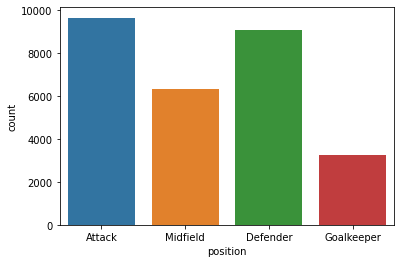

In [115]:
# bar plot of the number of players in each position
sns.countplot(x='position', data=players)

In [116]:
players[players['country_of_citizenship'] == 'Norway'].sort_values(by='market_value_in_eur', ascending=False).head(10)\
[['name', 'market_value_in_eur']]

,name,market_value_in_eur
23707,Erling Haaland,170000000.0
23787,Martin Ødegaard,60000000.0
17251,Sander Berge,16000000.0
23499,Kristoffer Ajer,16000000.0
26599,Fredrik Aursnes,13000000.0
24237,Mohamed Elyounoussi,12000000.0
27000,Jörgen Strand Larsen,11000000.0
27315,Alexander Sörloth,10000000.0
24806,Andreas Schjelderup,9000000.0
23525,Kristian Thorstvedt,8500000.0


<AxesSubplot:>

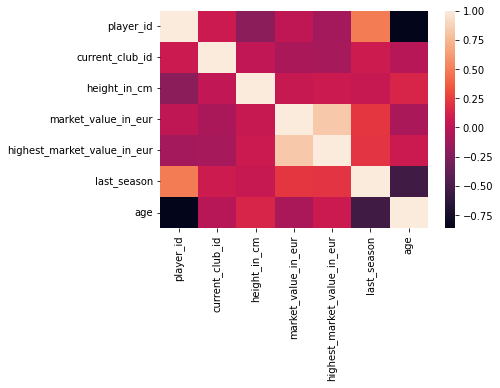

In [117]:
# make a heatmap of the correlation matrix
corr = players.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [118]:
# player above 50 years and market value is not NaN
players[(players['age'] >= 50) & (players['market_value_in_eur'].notna())][['name', 'age', 'market_value_in_eur', 'last_season']]

,name,age,market_value_in_eur,last_season
2953,Igor Shukhovtsev,51.0,1500000.0,2013
6855,Mark Schwarzer,50.0,100000.0,2015
